## Import needed libraries


In [128]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import v2
from tqdm.auto import tqdm, trange
from sklearn.metrics import classification_report

## Loading and Pre-Processing data

In [129]:
## Download FashionMNIST dataset
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5,), (0.5,))
                 ])
train_val_data = FashionMNIST(root="./data", transform=transforms, download=True)
test_data = FashionMNIST(root="./data", transform=transforms, download=True, train=False)
#################################################################################
#                                   THE END                                     #
#################################################################################

In [130]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# split training set into train and validation data
train_size = int(len(train_val_data)*0.85)
val_size = len(train_val_data) - train_size
train_data, val_data = random_split(train_val_data, [train_size, val_size])
#################################################################################
#                                   THE END                                     #
#################################################################################

In [131]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Loading the dataset into memory using Dataloader
# use your desired batch size and shuffle is necessary
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)

#################################################################################
#                                   THE END                                     #
#################################################################################

**Display some images from dataset**

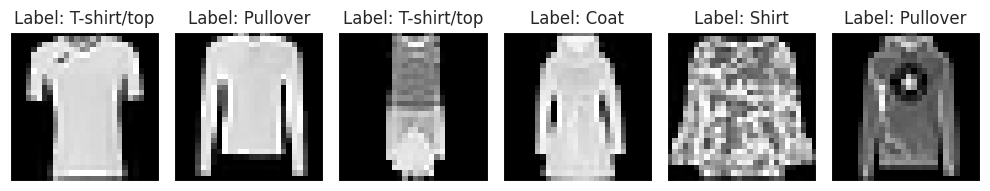

In [132]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
classes = train_val_data.classes
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,6),axes.flat):
    img,label=images[i],labels[i]
    ax.imshow(img.permute(1, 2, 0), cmap='gray')
    ax.set_title(f"Label: {classes[label]}")

plt.tight_layout()
plt.show()

# Defining the Convolutional Neural Network

<img src='https://drive.google.com/uc?id=1Euy5_bGIiiYECSZUeEofgTImJWgQ0XLf'>

**<h2>Implement the model above in pytorch</h2>**

In [133]:
import torch.nn as nn
import torch.nn.functional as F

#define the CNN architecture below
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        self.convolution = nn.Sequential(
        nn.Conv2d(1, 64, 3, padding=1),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2, 1),
        nn.GELU(),
        nn.Conv2d(64, 128, 3, padding=1),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2, 2, 1),
        nn.GELU()
        )
        with torch.inference_mode():
            output = self.convolution(torch.zeros(1, 1, 28, 28))
            output_dim = output.numel()
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(output_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
        )


#################################################################################
#                                   THE END                                     #
#################################################################################


#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
    def forward(self, x):
        conv = self.convolution(x)
        out = self.head(conv)

#################################################################################
#                                   THE END                                     #
#################################################################################

        return out

In [134]:
# Using GPU if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device : {device}")

device : cuda


In [135]:
cnn_model = Net().to(device, non_blocking=True)
cnn_model

Net(
  (convolution): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): GELU(approximate='none')
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (7): GELU(approximate='none')
  )
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): GELU(approximate='none')
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)

# Defining Loss Function and optimizer
**Define appropriate Loss Function, Optimizer and Learning Rate**

In [136]:
import torch.optim as optim

Learning_rate= 10 ** -3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=Learning_rate)

**Define number of epochs and path to save the best model**

In [137]:
n_epochs = 5
save_path="/content/cnn_model"

# Finally we will train our neural network

In [138]:
# multiclass accuracy
def multi_acc(y_pred, y_test):
    _, y_pred_tags = torch.max(y_pred, dim = 1)
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

**Implementing the training algorithm and Saving the model with minimum Validation Loss**

In [139]:
# training loop
def train_model(model, train_dataloader, val_dataloader, n_epochs, optimizer, criterion, device, save_path):
    train_losses = []
    val_losses = []
    model = model.to(device, non_blocking=True)

    valid_loss_min = np.inf
    valid_loss = 0.0

    scaler = torch.amp.GradScaler(device.type)


    # train for one epoch...


    for epoch in trange(0, n_epochs, desc="training one epooch", leave=True,):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        ####### Training Phase ########
        running_train_loss = 0.0
        running_val_loss = 0.0
        initial_params = [p.clone() for p in model.parameters()]
        pbar = tqdm(train_dataloader, desc="training ...", leave=False,gui=True)
        for x_train, y_train in pbar:
            x_train, y_train = x_train.to(device, non_blocking=True), y_train.to(device, non_blocking=True)

            model.train()
            optimizer.zero_grad()
            with torch.amp.autocast(device.type):
                train_preds = model(x_train)
                train_loss = criterion(train_preds, y_train)
            scaler.scale(train_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            # train_losses.append(train_loss.item())
            running_train_loss += train_loss.item()
            pbar.set_postfix(loss=train_loss)
        ####### Validation Phase ########
        model.eval()
        with torch.inference_mode(), torch.amp.autocast(device.type):
            for x_val, y_val in tqdm(val_dataloader, desc="evaluating ...", leave=False, gui=True):
                x_val, y_val = x_val.to(device, non_blocking=True), y_val.to(device, non_blocking=True)
                val_preds = model(x_val)
                val_loss = criterion(val_preds, y_val)
                # val_losses.append(val_loss.item())
                running_val_loss += val_loss.item()
        avg_val_loss = running_val_loss / len(val_dataloader)
        avg_train_loss = running_train_loss / len(train_dataloader)
        val_losses.append(avg_val_loss)
        train_losses.append(avg_train_loss)


        valid_loss = avg_val_loss
        changes = [((p0 - p1).abs().sum().item()) for p0, p1 in zip(initial_params, model.parameters())]
        print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.10f}, Validation Loss: {valid_loss:.10f}")
        print(f"Total weight change: {sum(changes)}")
#################################################################################
#                                   THE END                                     #
#################################################################################
        # print validation statistics
        print('Epoch: {}  Validation Loss: {:.6f}'.format(epoch+1, valid_loss))

        ## If the valiation loss has decreased, then saving the model
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    return model, train_losses, val_losses

**Train the model**

In [140]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################

model, train_losses, val_losses = train_model(cnn_model, train_dataloader, val_dataloader, n_epochs, optimizer, criterion, device, save_path)

#################################################################################
#                                   THE END                                     #
#################################################################################

training one epooch:   0%|          | 0/5 [00:00<?, ?it/s]

training ...:   0%|          | 0/1594 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.3692372968, Validation Loss: 0.2668983567
Total weight change: 43724.61938652396
Epoch: 1  Validation Loss: 0.266898
Validation loss decreased (inf --> 0.266898).  Saving model ...


training ...:   0%|          | 0/1594 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.2602176385, Validation Loss: 0.2490914330
Total weight change: 41926.20735245943
Epoch: 2  Validation Loss: 0.249091
Validation loss decreased (0.266898 --> 0.249091).  Saving model ...


training ...:   0%|          | 0/1594 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.2226210437, Validation Loss: 0.2088735196
Total weight change: 46972.03074552119
Epoch: 3  Validation Loss: 0.208874
Validation loss decreased (0.249091 --> 0.208874).  Saving model ...


training ...:   0%|          | 0/1594 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.1949095230, Validation Loss: 0.2089749868
Total weight change: 49969.09384008497
Epoch: 4  Validation Loss: 0.208975


training ...:   0%|          | 0/1594 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.1660064748, Validation Loss: 0.2078453743
Total weight change: 52543.15962930769
Epoch: 5  Validation Loss: 0.207845
Validation loss decreased (0.208874 --> 0.207845).  Saving model ...


In [141]:
train_losses

[0.36923729675533334,
 0.26021763851803026,
 0.22262104368830565,
 0.19490952302504289,
 0.16600647481296263]

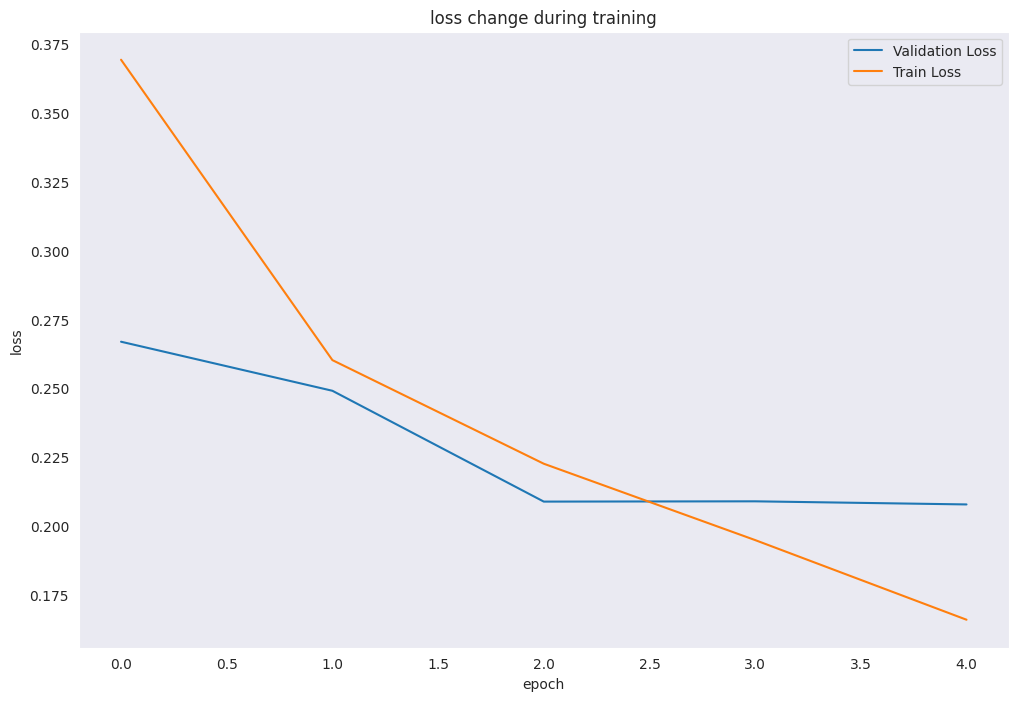

In [142]:
# plot losses
plt.subplots(figsize=(12, 8))
sns.set_style("dark")
sns.lineplot(data=val_losses,label="Validation Loss")
sns.lineplot(data=np.asarray(train_losses),label="Train Loss").set(title="loss change during training", xlabel="epoch", ylabel="loss")
plt.legend()
plt.show()

# Prediction on Test Data

In [143]:
train_losses, val_losses

([0.36923729675533334,
  0.26021763851803026,
  0.22262104368830565,
  0.19490952302504289,
  0.16600647481296263],
 [0.2668983566819142,
  0.2490914329648652,
  0.20887351958147177,
  0.20897498675324816,
  0.2078453742813134])

In [144]:
cnn_model.load_state_dict(torch.load(save_path))
cnn_model.eval()

def predict(images, model):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
    model.to(device, non_blocking = True)
    images = images.to(device, non_blocking = True)
    model.eval()
    with torch.inference_mode():
        test_preds = model(images)
    predicted = test_preds.argmax(dim=1)
#################################################################################
#                                   THE END                                     #
#################################################################################
    return predicted

**Accuracy Result on Test Data**

In [150]:
correct = 0
total = 0
y_pred_list = []
y_true_list = []
predicted = []
labels_list = []
with torch.no_grad():
    for data, labels in test_dataloader:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        test_pred = predict(data, cnn_model).cpu()
        correct += (labels == test_pred).sum().item()
        assert len(labels) == len(test_pred)
        total += len(labels)
        predicted.extend(test_pred)
        labels_list.extend(labels)
        y_true_list.extend(labels)
        y_pred_list.extend(test_pred)
#################################################################################
#                                   THE END                                     #
#################################################################################
    # for  x in predicted: y_pred_list.extend(x)
    # for  x in labels_list: y_true_list.extend(x)

print(f'Accuracy of the network on the 10000 test images: {(100 * correct / total):.4f}')

Accuracy of the network on the 10000 test images: 92.2000


**Classification report**

In [156]:
import pandas as pd

x = classification_report(y_true_list, y_pred_list, target_names=classes, output_dict=True)
pd.DataFrame(x).transpose()

,precision,recall,f1-score,support
T-shirt/top,0.873016,0.880,0.876494,1000.000
Trouser,0.996970,0.987,0.991960,1000.000
Pullover,0.892970,0.851,0.871480,1000.000
Dress,0.896422,0.952,0.923375,1000.000
Coat,0.880490,0.862,0.871147,1000.000
Sandal,0.986083,0.992,0.989033,1000.000
Shirt,0.764356,0.772,0.768159,1000.000
Sneaker,0.959725,0.977,0.968285,1000.000
Bag,0.989950,0.985,0.987469,1000.000
Ankle boot,0.982635,0.962,0.972208,1000.000


**Displaying a random set of images from test data**

In [ ]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
predicted=predict(images,cnn_model)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,16),axes.flat):
    img,label=images[i],labels[i]
    pred=predicted[i]
    ax.imshow(img.permute(1, 2, 0), cmap='gray')
    ax.set_title(f"True: {classes[label]}\n Predicted: {classes[pred]}")

plt.tight_layout()
plt.show()